inspired from: https://youtu.be/cEgF0YknpZw

## Setup

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1, 2, 3' 

In [2]:
# !python -m pip install pyyaml==5.1
import sys, os, distutils.core
# !git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [4]:
DEVICE = 'cuda:3'

In [5]:
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

matplotlib data path: /opt/conda/envs/env_py311/lib/python3.11/site-packages/matplotlib/mpl-data
CONFIGDIR=/root/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/root/.cache/matplotlib
Using fontManager instance from /root/.cache/matplotlib/fontlist-v330.json


## Create configuration

In [6]:
dataset_train = 'my_dataset_train4'
dataset_val = 'my_dataset_val4'

In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances(dataset_train, {}, "./roboflow_datasets/xmm_om_artefacts_512-3-COCO/train/_annotations.coco.json", "./roboflow_datasets/xmm_om_artefacts_512-3-COCO/train")
register_coco_instances(dataset_val, {}, "./roboflow_datasets/xmm_om_artefacts_512-3-COCO/valid/_annotations.coco.json", "./roboflow_datasets/xmm_om_artefacts_512-3-COCO/valid")

In [8]:
train_metadata = MetadataCatalog.get(dataset_train)
train_dataset_dicts = DatasetCatalog.get(dataset_val)

WARNING [03/19 10:55:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/19 10:55:47 d2.data.datasets.coco]: Loaded 289 images in COCO format from ./roboflow_datasets/xmm_om_artefacts_512-3-COCO/valid/_annotations.coco.json


In [9]:
val_metadata = MetadataCatalog.get(dataset_train)
val_dataset_dicts = DatasetCatalog.get(dataset_val)

WARNING [03/19 10:55:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/19 10:55:47 d2.data.datasets.coco]: Loaded 289 images in COCO format from ./roboflow_datasets/xmm_om_artefacts_512-3-COCO/valid/_annotations.coco.json


In [10]:
from matplotlib import pyplot as plt

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/opt/conda/envs/env_py311/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/opt/conda/envs/env_py311/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/opt/conda/envs/env_py311/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/opt/conda/envs/env_py311/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal'

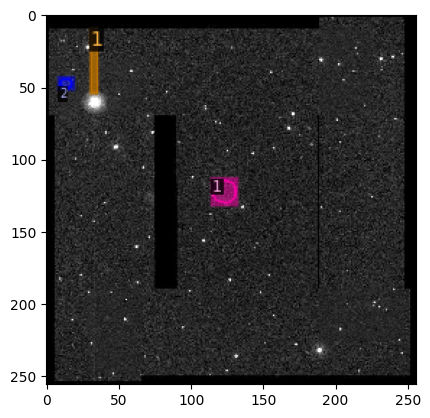

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=7.03369066119194.
findfont: score(FontEntry(fname='/opt/conda/envs/env_py311/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/opt/conda/envs/env_py311/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/opt/conda/envs/env_py311/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/opt/conda/envs/env_py311/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', st

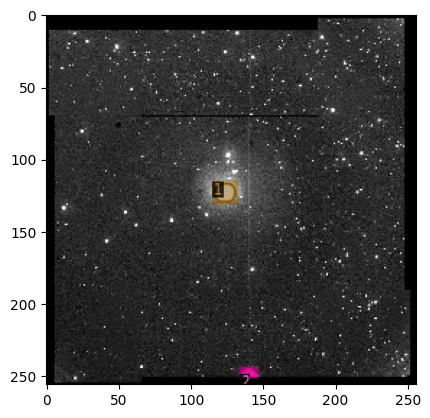

In [11]:
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [12]:
import wandb
wandb.login()
wandb.init(project='ft_detectron2', sync_tensorboard=True)

Popen(['git', 'version'], cwd=/workspace/raid/OM_DeepLearning/XMM_OM_code_git, stdin=None, shell=False, universal_newlines=False)
Popen(['git', 'version'], cwd=/workspace/raid/OM_DeepLearning/XMM_OM_code_git, stdin=None, shell=False, universal_newlines=False)
Trying paths: ['/root/.docker/config.json', '/root/.dockercfg']
No config file found
[Tracing] Create new propagation context: {'trace_id': '067e17ef697945c4b93dede464be859b', 'span_id': 'bbcaee9bf0b6cb07', 'parent_span_id': None, 'dynamic_sampling_context': None}
Starting new HTTP connection (1): localhost:8887
http://localhost:8887 "GET /api/sessions?token= HTTP/1.1" 403 40


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Starting new HTTPS connection (1): api.wandb.ai:443
https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


wandb: Currently logged in as: iuliaelisa15. Use `wandb login --relogin` to force relogin
2024-03-19 10:55:49.584886: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
Creating converter from 7 to 5
Creating converter from 5 to 7
Creating converter from 7 to 5
Creating converter from 5 to 7


2024-03-19 10:55:50.421149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Popen(['git', 'cat-file', '--batch-check'], cwd=/workspace/raid/OM_DeepLearning/XMM_OM_code_git, stdin=<valid stream>, shell=False, universal_newlines=False)


In [13]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "./output_detectron2"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (dataset_train,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 16 # BATCH_SIZE
cfg.SOLVER.BASE_LR = 0.0003  # pick a good LR
cfg.SOLVER.MAX_ITER = 50000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.PIXEL_MEAN = [38, 38, 38]
cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0]
cfg.SOLVER.BASE_LR_END = 0.0
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 # number of classes, without the background!
cfg.SOLVER.AMP.ENABLED = True
cfg.SOLVER.WEIGHT_DECAY = 0.00005
cfg.MODEL.DEVICE = 'cuda:0'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

IN GENERALIZED RCNN INIT
[03/19 10:56:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
   

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

## Traintrainer

In [ ]:
trainer.train() 

[03/19 10:56:10 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/envs/env_py311/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/envs/env_py311/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[03/19 10:56:22 d2.utils.events]:  eta: 6:32:35  iter: 19  total_loss: 3.267  loss_cls: 1.458  loss_box_reg: 0.1069  loss_mask: 0.6901  loss_rpn_cls: 0.9123  loss_rpn_loc: 0.08736    time: 0.4869  last_time: 0.4746  data_time: 0.1190  last_data_time: 0.1123   lr: 5.9943e-06  max_mem: 5425M


2024-03-19 10:56:23.358028: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 10:56:24.260552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[03/19 10:56:32 d2.utils.events]:  eta: 6:27:59  iter: 39  total_loss: 2.603  loss_cls: 1.136  loss_box_reg: 0.08882  loss_mask: 0.6877  loss_rpn_cls: 0.6583  loss_rpn_loc: 0.08533    time: 0.4731  last_time: 0.4512  data_time: 0.1113  last_data_time: 0.1162   lr: 1.1988e-05  max_mem: 5431M
[03/19 10:56:41 d2.utils.events]:  eta: 6:26:26  iter: 59  total_loss: 2.002  loss_cls: 0.6959  loss_box_reg: 0.08935  loss_mask: 0.6827  loss_rpn_cls: 0.4444  loss_rpn_loc: 0.08367    time: 0.4724  last_time: 0.4651  data_time: 0.1101  last_data_time: 0.1173   lr: 1.7982e-05  max_mem: 5456M
[03/19 10:56:50 d2.utils.events]:  eta: 6:24:33  iter: 79  total_loss: 1.508  loss_cls: 0.376  loss_box_reg: 0.1016  loss_mask: 0.6766  loss_rpn_cls: 0.2894  loss_rpn_loc: 0.08731    time: 0.4710  last_time: 0.6743  data_time: 0.1078  last_data_time: 0.1048   lr: 2.3976e-05  max_mem: 5463M
[03/19 10:56:59 d2.utils.events]:  eta: 6:22:16  iter: 99  total_loss: 1.292  loss_cls: 0.2226  loss_box_reg: 0.08901  loss_

In [ ]:
import yaml
# Save configuration
config_yaml_path = "./detr2_config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference using the trained model

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
predictor = DefaultPredictor(cfg)

Verify segmentation on random validation images

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(dataset_val, output_dir="./output_detectron2")
val_loader = build_detection_test_loader(cfg,dataset_val)
print(inference_on_dataset(predictor.model, val_loader, evaluator))

In [ ]:
new_im = cv2.imread("../XMM_OM_dataset/zscaled_512_stretched/S0005010301_L.png")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.imshow(out.get_image()[:, :, ::-1])

## Export new annotations to Roboflow

In [ ]:
import glob
from roboflow import Roboflow

import dataset 
from dataset import dataset_utils

export_to_Roboflow = False

if export_to_Roboflow:
    # Initialize Roboflow client
    rf = Roboflow(api_key="EBeK30tpU3HW2VGGl0xa")
    upload_project = rf.workspace("orij").project("xmm_om_images_512_sg_sr_cr_only") # error if the project doesn't exist
    
def export_image_det_to_Roboflow(input_dir, filename, masks, class_label, boxes):
        
        objects = []
        for i in range(len(masks)):
            mask_np = masks[i] # [H, W]
            polygon = binary_image_to_polygon(mask_np)
            bbox = boxes[i]
            if class_label[i] != 'star' and class_label[i] != 'other': # ignore stars and 'other' label
                objects.append({
                    'name': train_metadata.thing_classes[class_label[i]],
                    'bbox': bbox,
                    'segmentations': polygon[0]
                })
        if len(objects)>0:
            create_annotation_SAM(filename=filename, width=512, height=512, depth=3, objects=objects) # generating xml file for VOC format
            image_path = input_dir+filename
            annotation_filename = filename.replace(".png", ".xml")
            upload_project.upload(image_path, annotation_filename, overwrite=True)
            os.remove(annotation_filename)
        else:
            print("No objects after label filtering.")

    
# Directory path to the input images folder
input_images_directory = "../XMM_OM_dataset/zscaled_512_stretched/"

# Output directory where the segmented images will be saved
output_directory = "."  
import time
for image_filename in os.listdir(input_images_directory)[2001:2010]:
    if not image_filename.endswith('.json'):
        print(image_filename)
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)
        start_time = time.time()
        # Perform prediction on the new image
        outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        instances = outputs["instances"]
        print("Inference time per image:", time.time()-start_time)

        if instances.has("pred_masks") and instances.has("pred_classes"):
            masks = instances.pred_masks.to("cpu").numpy()  # A binary mask of shape [num_instances, H, W]
            classes = instances.pred_classes.to("cpu").numpy()  # An array of class IDs for each instance
            scores = instances.scores.to("cpu").numpy()  # An array of scores for each instance
            boxes = instances.pred_boxes.tensor.to("cpu").numpy()  # An array of bounding boxes for each instance, shape [num_instances, 4]
            if export_to_Roboflow:
                export_image_det_to_Roboflow(input_images_directory, image_filename, masks, classes, boxes)
            plt.imshow(new_im)
            plt.title('Detectron2 Masks')
            dataset_utils.show_masks(masks, plt.gca()) #, random_color=True)
            # plt.savefig('./plots/detr2_masks.png')
            plt.show()
            plt.close()

print("Segmentation of all images completed.")